In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
#imports
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

import tensorflow as tf
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B1
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip
from tensorflow.keras.regularizers import l2

2023-09-07 19:34:47.145978: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-07 19:34:47.345093: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-07 19:34:48.360532: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [10]:
training_directory_url = "https://www.kaggle.com/datasets/gusshepherd/split-balanced-data-bad-removed/train"
val_directory_url = "https://www.kaggle.com/datasets/gusshepherd/split-balanced-data-bad-removed/validation"
test_directory_url = "https://www.kaggle.com/datasets/gusshepherd/split-balanced-data-bad-removed/test"

In [11]:
Xy_train = image_dataset_from_directory(
    directory= training_directory_url,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

NotFoundError: Could not find directory https://www.kaggle.com/datasets/gusshepherd/split-balanced-data-bad-removed/train

In [7]:
Xy_val = image_dataset_from_directory(
    directory= val_directory_url,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False)

NotFoundError: Could not find directory /kaggle/input/split-balanced-data-bad-removed/split_balanced_data_bad_removed/validation

In [ ]:
base_model = EfficientNetV2B1(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
model = Sequential([
    RandomFlip('horizontal'),
    base_model,
    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.011)),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.011)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(9, activation='softmax')
])

In [6]:
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

In [5]:
Xy_val_preprocessed = Xy_val.map(lambda x, y: (preprocess_input(x), y))
Xy_val_preprocessed

NameError: name 'Xy_val' is not defined

In [ ]:
Xy_train_preprocessed = Xy_train.map(lambda x, y: (preprocess_input(x), y))

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=4,           
    restore_best_weights=True  
)

lr = ReduceLROnPlateau(monitor="val_loss",
                       factor=0.1,
                       patience=2,
                       verbose=1,
                       min_lr=0)
mcp = ModelCheckpoint("{}.h5".format('model_name'),
                      save_weights_only=False,
                      monitor='val_accuracy',
                      mode='max',
                      verbose=0,
                      save_best_only=True)


In [ ]:
opt = optimizers.Adam(learning_rate=1e-4)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])


history = model.fit(
    Xy_train_preprocessed,
    epochs=200,  
    validation_data=Xy_val_preprocessed,
    verbose=1,
    callbacks=[early_stopping, lr, mcp]
)

Epoch 1/200


2023-09-07 15:11:08.999737: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/efficientnetv2-b1/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


53/53 [==============================] - 31s 342ms/step - loss: 1.3446 - accuracy: 0.9623 - val_loss: 1.6962 - val_accuracy: 0.8377 - lr: 1.0000e-04
Epoch 2/200
53/53 [==============================] - 19s 337ms/step - loss: 1.3023 - accuracy: 0.9646 - val_loss: 1.6358 - val_accuracy: 0.8436 - lr: 1.0000e-04
Epoch 3/200
53/53 [==============================] - 18s 303ms/step - loss: 1.2600 - accuracy: 0.9676 - val_loss: 1.6064 - val_accuracy: 0.8531 - lr: 1.0000e-04
Epoch 4/200
53/53 [==============================] - 18s 314ms/step - loss: 1.2184 - accuracy: 0.9693 - val_loss: 1.5332 - val_accuracy: 0.8649 - lr: 1.0000e-04
Epoch 5/200
53/53 [==============================] - 16s 280ms/step - loss: 1.1701 - accuracy: 0.9770 - val_loss: 1.6484 - val_accuracy: 0.8329 - lr: 1.0000e-04
Epoch 6/200
53/53 [==============================] - 17s 301ms/step - loss: 1.1905 - accuracy: 0.9599 - val_loss: 1.5255 - val_accuracy: 0.8424 - lr: 1.0000e-04
Epoch 7/200
53/53 [===========================

In [ ]:
# Evaluate the model on the validation dataset
accuracy = model.evaluate(Xy_val_preprocessed, verbose=1)

# Print the accuracy
print(f"Validation Accuracy: {accuracy[1] * 100:.2f}%")

27/27 [==============================] - 6s 158ms/step - loss: 1.2589 - accuracy: 0.8732
Validation Accuracy: 87.32%


In [ ]:
import matplotlib.pyplot as plt

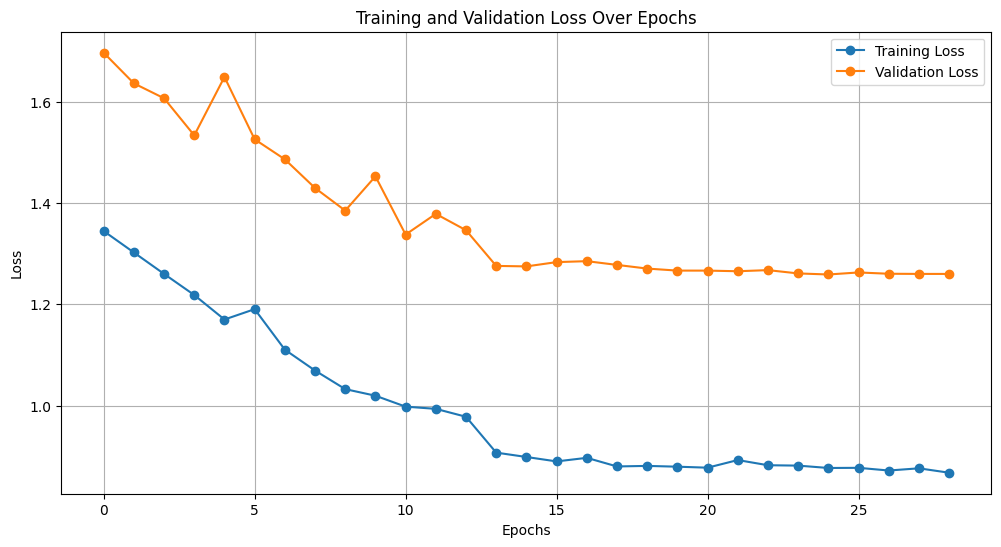

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Training Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
Xy_test = image_dataset_from_directory(
    directory= test_directory_url,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True, #shuffle is true to be the same a sthe training set
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False)

Xy_test_preprocessed = Xy_test.map(lambda x, y: (preprocess_input(x), y))

Found 900 files belonging to 9 classes.


In [ ]:
test_result = model.evaluate(Xy_test_preprocessed, verbose=1)

29/29 [==============================] - 6s 153ms/step - loss: 1.5839 - accuracy: 0.8289


In [ ]:
Xy_test = image_dataset_from_directory(
    directory= test_directory_url,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=False, #shuffle is false so thge classification report can compare y_true and y_pred
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False)

Xy_test_preprocessed = Xy_test.map(lambda x, y: (preprocess_input(x), y))

Found 900 files belonging to 9 classes.


In [9]:
#prediction
y_pred_encoded = model.predict(Xy_test_preprocessed, batch_size=32)


NameError: name 'model' is not defined

In [ ]:
y_pred_class_num = np.argmax(y_pred_encoded, axis=1)

In [ ]:
y_pred_class_num

array([0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 7, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 5, 0, 0, 0, 0,
       2, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 6, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 6, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 2, 1, 1, 5, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 3,
       1, 1, 2, 1, 2, 2, 0, 2, 2, 3, 2, 2, 3, 2, 0, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 5, 2, 1, 2, 2, 2, 2, 2, 2, 3, 3,

In [ ]:
Xy_test_preprocessed_unbatched = Xy_test_preprocessed.unbatch()
y_true_encoded = np.array(list(Xy_test_preprocessed_unbatched.map(lambda x, y:  y)))

In [ ]:
y_true_encoded

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [ ]:
y_true= np.argmax(y_true_encoded, axis=1)

In [ ]:
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,

In [ ]:
from sklearn.metrics import classification_report
classes = ['737', '747','767','A340','CRJ','DC','DHC','E','MD']
report = classification_report(y_true, y_pred_class_num, target_names=classes)

In [ ]:
print(report)

              precision    recall  f1-score   support

         737       0.87      0.92      0.89       100
         747       0.82      0.84      0.83       100
         767       0.78      0.87      0.82       100
        A340       0.89      0.92      0.91       100
         CRJ       0.91      0.94      0.93       100
          DC       0.61      0.71      0.65       100
         DHC       0.87      0.97      0.92       100
           E       0.96      0.69      0.80       100
          MD       0.83      0.60      0.70       100

    accuracy                           0.83       900
   macro avg       0.84      0.83      0.83       900
weighted avg       0.84      0.83      0.83       900



test_image = ""
model.predict(test_image)